Analyze the results from LSTM

Note that we always assume speed is static

In [128]:
RUN_PYTHON_SCRIPT = False

False

In [129]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [130]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [131]:
import importlib
import models.lstm
importlib.reload(models.lstm)

<module 'models.lstm' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/lstm.py'>

In [132]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from utils.standardize import std_mat, std_vec

In [133]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data, fn and paras

In [134]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all = 10 * np.log10(psd_all)
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

all_data = psd_all.transpose(3, 2, 0, 1)
all_data_std = (all_data - all_data.mean(axis=-1, keepdims=True))/all_data.std(axis=-1, keepdims=True);

In [135]:
base_corrs = load_pkl_folder2dict(DATA_ROOT/(fils[0].stem+"_base_1000"), including=["*"], verbose=False);

In [136]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [137]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = np.array(["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"])

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [138]:
std_fn = lambda x: (x-x.mean(axis=-1, keepdims=True))/x.std(axis=-1, keepdims=True)

<function __main__.<lambda>(x)>

In [139]:
def ana_corr(data_org, data_rec):
    corrs_psd = []
    for ix in range(data_org.shape[0]):
        seq_x = data_org[ix]
        seq_y = data_rec[ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_psd.append(res[0])
        
        
    data_org_std = std_mat(data_org)
    data_rec_std = std_mat(data_rec)
    corr_psd_uni = scipy.stats.pearsonr(
        data_org_std.mean(axis=0), 
        data_rec_std.mean(axis=0))[0]
    
    return corr_psd_uni, corrs_psd

# Load the model

In [140]:
trained_model_sgm = load_pkl_folder2dict(RES_ROOT/"SGM_net_large", excluding=['opt*']);
sgm_net = trained_model_sgm.model;

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/paras.pkl


In [187]:
all_models = list(RES_ROOT.glob("LSTM_simu_net_linR*"));
for cur_model_p in tqdm(all_models):
    cur_model = load_pkl_folder2dict(cur_model_p, including=["corrss", "corrss_roiwise"], verbose=False);
    if "corrss" not in cur_model.keys():
        cur_model = load_pkl_folder2dict(cur_model_p, including=["Rec_PSD", "corrss", "corrss_roiwise"], verbose=False);
        if "Rec_PSD" not in cur_model.keys():
            continue
        corrss = []
        corrss_roiwise = []
        X_recs = 20*np.log10(cur_model.Rec_PSD)
        X_recs_std = (X_recs - X_recs.mean(axis=-1, keepdims=True))/X_recs.std(axis=-1, keepdims=True)
        for X_org, X_rec in zip(all_data_std, X_recs_std):
        #for X_org, X_rec in tqdm(zip(all_data_std, X_recs_std), total=len(X_recs_std)):
            corrs = []
            corrs_roiwise = []
            for ix in range(len(X_org)):
                res =ana_corr(X_org[ix], X_rec[ix])
                
                corrs.append(res[0])
                corrs_roiwise.append(res[1])
            
            corrss.append(corrs)
            corrss_roiwise.append(corrs_roiwise)
            
        cur_model.corrss = corrss
        cur_model.corrss_roiwise = corrss_roiwise
        save_pkl_dict2folder(cur_model_p, cur_model, is_force=False)
    else:
        print(f"{cur_model_p.stem} already has corrs")
    
    

 33%|██████████████████████████████████████████████▋                                                                                             | 1/3 [00:00<00:00,  2.24it/s]

LSTM_simu_net_linR already has corrs


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2/3 [00:00<00:00,  2.16it/s]

LSTM_simu_net_linR_tau already has corrs


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]

LSTM_simu_net_linR_alpha_gei_gii_Taue_TauG_Taui already has corrs


# Analysis

## prepare

In [188]:
def _extract_base(sub_ix, key="mean", is_roiwise=False):
    """extract from base corr file"""
    if is_roiwise:
        item = f"regR_roiwise_{sub_ix}"
    else:
        item = f"regR_{sub_ix}"
    return np.array([cor[key] for cor in base_corrs[item]])

In [189]:
def _stat_paras_fn(path):
    """Return the static paras name given model saved path
    """
    statics = path.stem.split("_")[4:]
    statics = [ix for ix in statics if len(ix) >0]
    if statics == ["tau"]:
        statics = ["Taue", "TauG", "Taui"]
    elif statics == ["gain"]:
        statics = ["gei", "gii"]
    return statics

def _order_key_fn(stat_set):
    """Return an order key given the static set
       More static paras, larger
    """
    num_v = len(stat_set) * 1e3
    order_v = np.sum([list(paras.names).index(ix) for ix in stat_set])
    return num_v + order_v

_key_fn = lambda p : _order_key_fn(_stat_paras_fn(p))

<function __main__.<lambda>(p)>

In [190]:
# get base roi
base_corr_mean = np.array([_extract_base(ix) for ix in range(36)]);
base_corr_median = np.array([_extract_base(ix, key="median") for ix in range(36)]);
base_corr_std = np.array([_extract_base(ix, key="std") for ix in range(36)]);
base_corr_roiwise_mean = np.array([_extract_base(ix, is_roiwise=True) for ix in range(36)]);
base_corr_roiwise_median = np.array([_extract_base(ix, key="median", is_roiwise=True) for ix in range(36)]);
base_corr_roiwise_std = np.array([_extract_base(ix, key="std", is_roiwise=True) for ix in range(36)]);

_std_corr = lambda corr: (np.array(corr) - base_corr_mean)/base_corr_std
_std_corr_roiwise = lambda corr: (np.array(corr) - base_corr_roiwise_mean)/base_corr_roiwise_std;

In [191]:
all_models = sorted(all_models, key=_key_fn);

## Test whether we need dynamic or not

In [192]:
def _tests_res(vec1, vec2):
    test_res = edict()
    test_res.ttest_ind = scipy.stats.ttest_ind(vec1, vec2)
    test_res.ttest_ind_nonparam = scipy.stats.mannwhitneyu(vec1, vec2)
    test_res.ttest_paired = scipy.stats.ttest_rel(vec1, vec2)
    test_res.ttest_paired_nonparam = scipy.stats.wilcoxon(vec1, vec2)
    df = pd.DataFrame.from_dict(test_res, orient='index', columns=['Statistic', 'P-Value'])
    df = df.drop("Statistic", axis=1)
    return df 

In [193]:
full_model = load_pkl_folder2dict(all_models[0], excluding=["loss_fn", "opt*", "Rec*"], verbose=False);
null_model = load_pkl_folder2dict(all_models[-1], excluding=["loss_fn", "opt*", "Rec*"], verbose=False);

In [194]:
corr_roi_mean_full = _std_corr_roiwise(full_model.corrss_roiwise).mean(axis=(-1, -2));
corr_roi_mean_null = _std_corr_roiwise(null_model.corrss_roiwise).mean(axis=(-1, -2));

,P-Value
ttest_ind,2.606777e-02
ttest_ind_nonparam,2.064576e-02
ttest_paired,1.356866e-12
ttest_paired_nonparam,1.680296e-07


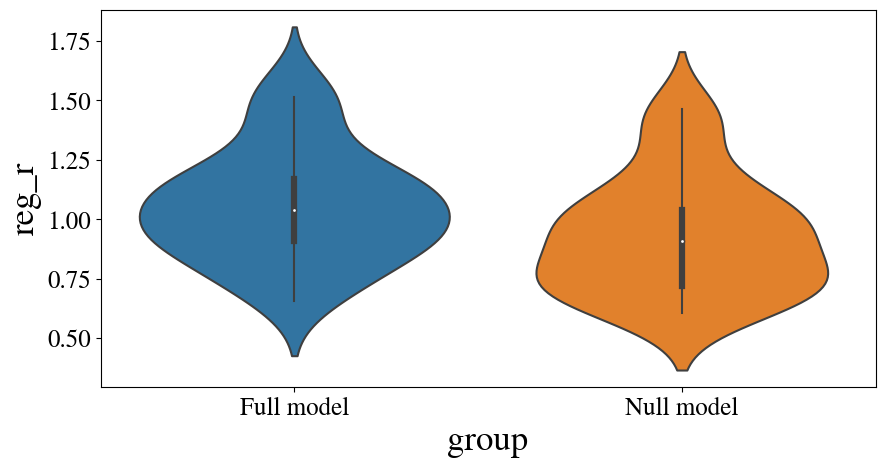

In [195]:
df = edict()
df.reg_r = np.concatenate([corr_roi_mean_full.flatten(), corr_roi_mean_null.flatten()]);
df.group = ["Full model"]*corr_roi_mean_full.size + ["Null model"]*corr_roi_mean_null.size
df = pd.DataFrame(df);
sns.violinplot(data=df, y="reg_r", x="group")
_tests_res(corr_roi_mean_full, corr_roi_mean_null)

## Model selection

In [196]:
corr_dict = edict()

for cur_model_p in all_models:
    stat_paras = _stat_paras_fn(cur_model_p)
    if len(stat_paras) not in [0, 1, 6]:
        continue
    else:
        cur_model = load_pkl_folder2dict(cur_model_p, excluding=["loss_fn", "opt*", "Rec*"], verbose=False);
        corr = np.mean(_std_corr_roiwise(cur_model.corrss_roiwise), axis=(-1, -2))
        if len(stat_paras) == 0:
            corr_dict["No"] = corr
        elif len(stat_paras) == 6:
            corr_dict["All"] = corr
        else:
            corr_dict[stat_paras[0]] = corr
            

### All 36 subjs

In [197]:
def _boot_CI(vec, num_boot=10000, bds=[0.025, 0.975]):
    boot_sps = np.random.choice(vec, size=len(vec)*num_boot, replace=True).reshape(len(vec), -1)
    boot_m = boot_sps.mean(axis=0)
    return np.quantile(boot_m, bds)

ValueError: x and y must have same first dimension, but have shapes (8,) and (2,)

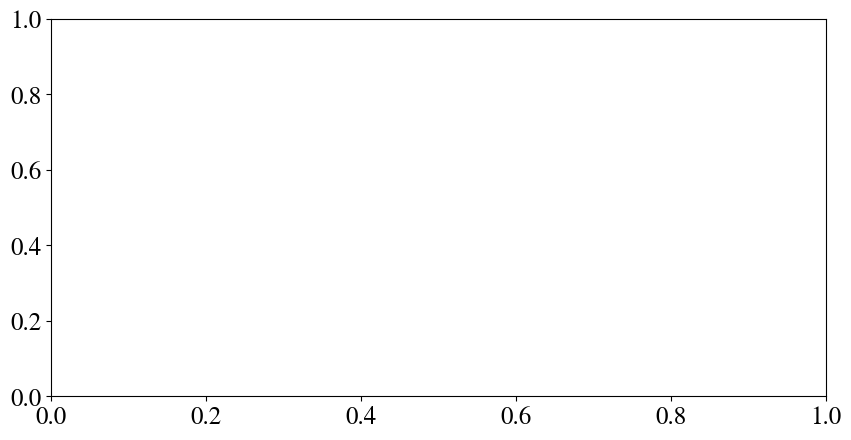

In [198]:
keys = np.array(list(corr_dict.keys()))
corr_m = np.array([corr_dict[key].mean() for key in keys])
corr_se = np.array([corr_dict[key].std()/np.sqrt(corr_dict[key].size) for key in keys])

sort_idxs = np.argsort(-corr_m)
keys, corr_m, corr_se = keys[sort_idxs], corr_m[sort_idxs], corr_se[sort_idxs]
corr_boot_CIs = np.array([_boot_CI(corr_dict[key]) for key in keys])
corr_normal_CIs = np.stack([corr_m-1.96*corr_se,  corr_m+1.96*corr_se]).T


cur_CIs = corr_boot_CIs
x_labs = list(range(8))
plt.plot(x_labs, corr_m, "o--")
plt.fill_between(x_labs, y1=cur_CIs[:, 0], y2=cur_CIs[:, 1], color="red", alpha=0.3)
plt.xticks(x_labs, keys);
plt.axhline(y=cur_CIs[0, 0], color="dodgerblue", ls="-.", lw=0.5)
plt.xlabel("Static parameters")
plt.ylabel("Pearson's R after removing baseline")

In [199]:
pd.DataFrame({
    "Name": keys, 
    "Corr": corr_m, 
    "95% Low Normal": corr_normal_CIs[:, 0],
    "95% Up Normal": corr_normal_CIs[:, 1],
    "95% Low Boot": corr_boot_CIs[:, 0],
    "95% Up Boot": corr_boot_CIs[:, 1]
})

,Name,Corr,95% Low Normal,95% Up Normal,95% Low Boot,95% Up Boot
0,No,1.057268,0.981075,1.133461,0.982325,1.134122
1,All,0.928175,0.849201,1.007148,0.851184,1.009271


### Subj wise

Text(0, 0.5, "Normalized Pearson's R")

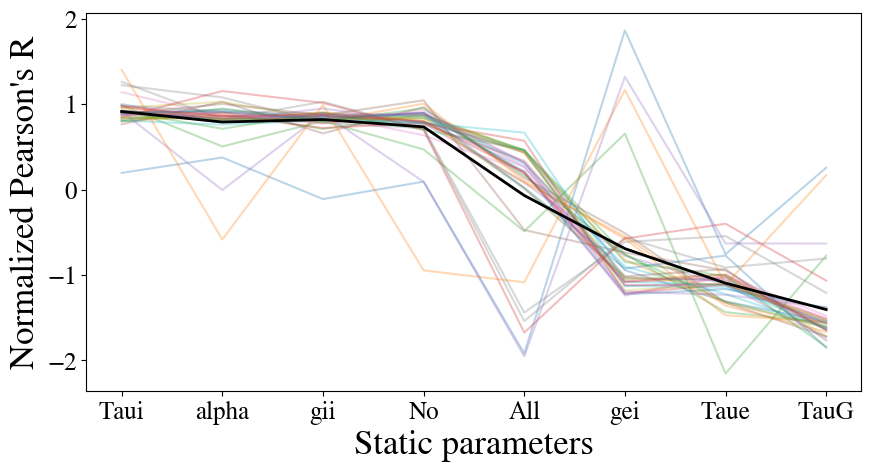

In [172]:
corr_sub_m = np.array([corr_dict[key] for key in keys])

x_labs = list(range(8))
for sub_ix in range(corr_sub_m.shape[1]):
    plt.plot(x_labs, std_fn(corr_sub_m[:, sub_ix]), "-", alpha=0.3)
plt.plot(x_labs, std_fn(corr_sub_m.T).T.mean(axis=-1), "k-", lw=2)
plt.xticks(x_labs, keys);
plt.xlabel("Static parameters")
plt.ylabel("Normalized Pearson's R")

In [200]:
for cur_model_p in all_models:
    stat_paras = _stat_paras_fn(cur_model_p)
    cur_model = load_pkl_folder2dict(cur_model_p, excluding=["loss_fn", "opt*", "Rec*"], verbose=False);
    corr = np.mean(_std_corr_roiwise(cur_model.corrss_roiwise), axis=(-1, -2))
    print(corr.mean(), stat_paras)


1.057268144812863 []
0.9950167662230736 ['Taue', 'TauG', 'Taui']
0.9281746926707449 ['alpha', 'gei', 'gii', 'Taue', 'TauG', 'Taui']


## The selected model

no `gei` and `gii`

In [66]:
sel_stat_set = ["gei", "gii"]
sel_model_p = [cur_model_p for cur_model_p in all_models if _stat_paras_fn(cur_model_p) == sel_stat_set][0]
sel_model = load_pkl_folder2dict(sel_model_p, excluding=["loss_fn", "opt*"], verbose=False);
full_model = load_pkl_folder2dict(all_models[0], excluding=["loss_fn", "opt*", "Rec*"], verbose=False);

In [67]:
corr_roi_mean_full = _std_corr_roiwise(full_model.corrss_roiwise).mean(axis=-1);
corr_roi_mean_sel = _std_corr_roiwise(sel_model.corrss_roiwise).mean(axis=-1);

<AxesSubplot:xlabel='group', ylabel='reg_r'>

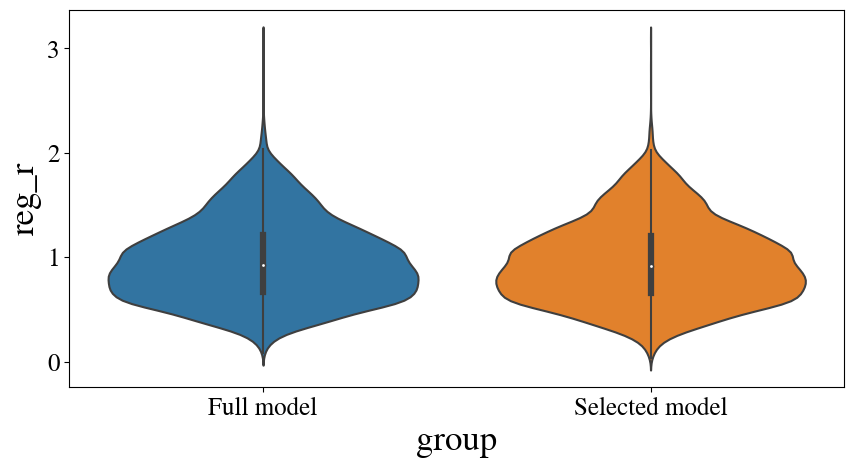

In [68]:
df = edict()
df.reg_r = np.concatenate([corr_roi_mean_full.flatten(), corr_roi_mean_sel.flatten()]);
df.group = ["Full model"]*corr_roi_mean_full.size + ["Selected model"]*corr_roi_mean_sel.size
df = pd.DataFrame(df);
sns.violinplot(data=df, y="reg_r", x="group")

In [76]:
scipy.stats.ttest_ind(corr_roi_mean_full.mean(axis=1),  corr_roi_mean_sel.mean(axis=1))

Ttest_indResult(statistic=0.1549472691608051, pvalue=0.8773088044104409)

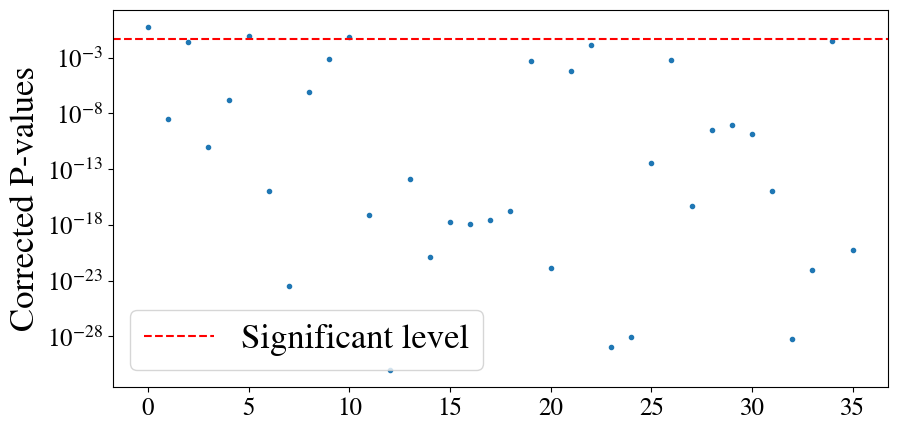

In [72]:
from statsmodels.sandbox.stats.multicomp import multipletests
res = scipy.stats.ttest_rel(
    corr_roi_mean_full.T, 
    corr_roi_mean_sel.T, 
)
                      
reject, pvals_corrected, _, _ = multipletests(res.pvalue, alpha=0.05, method='fdr_bh')

plt.plot(pvals_corrected, ".")
plt.ylabel("Corrected P-values")
plt.axhline(y=0.05, ls="--", 
            color="red",  
            label="Significant level")
plt.yscale("log")
plt.legend()

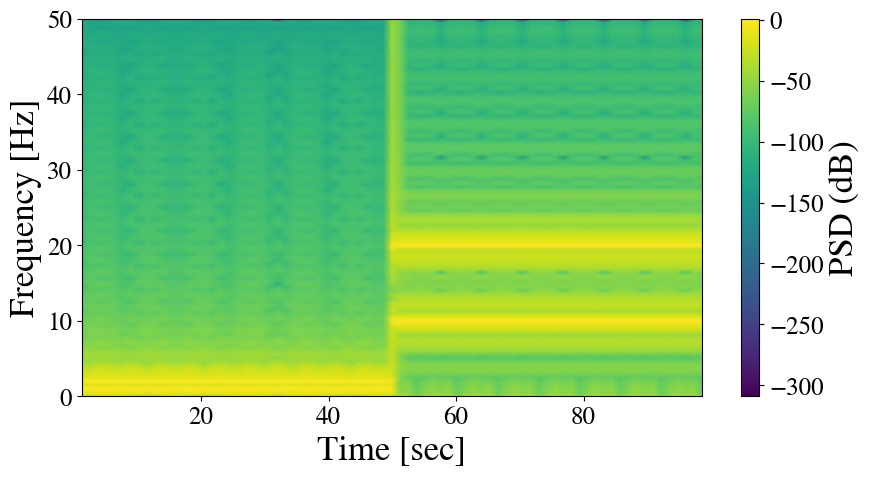

In [117]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# 创建一个模拟的时间序列
fs = 100  # 采样频率
T = 100  # 时间长度
T1 = int(T/2)
t1 = np.linspace(0, T1, T1*fs, endpoint=False) # 时间向量
T2 = T - T1
t2 = np.linspace(0, T2, T2*fs, endpoint=False) # 时间向量
x1 = np.sin(2*np.pi*1*t1) + np.sin(2*np.pi*2*t1) # 模拟的时间序列
x2 = np.sin(2*np.pi*10*t2) + np.sin(2*np.pi*20*t2) # 模拟的时间序列
x = np.concatenate([x1, x2])

# 使用scipy.signal.spectrogram计算
frequencies, times, Sxx = signal.spectrogram(x, fs, mode="psd", scaling="density", noverlap=128)
frequencies, times, Sxx1 = signal.spectrogram(x, fs, mode="psd", scaling="spectrum", noverlap=128)

# 绘制spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='PSD (dB)')
plt.show()


In [119]:
Sxx

array([[4.51512676e-03, 4.12699389e-03, 1.37650014e-03, ...,
        4.78030588e-05, 1.99424389e-04, 3.33280980e-06],
       [3.82013044e-02, 1.33913839e-02, 6.63909650e-02, ...,
        1.84205000e-06, 5.23453187e-06, 3.54361020e-08],
       [2.84215568e-01, 2.29716911e-01, 3.44789448e-01, ...,
        1.49664756e-06, 4.14829305e-06, 7.35902252e-08],
       ...,
       [3.43557954e-13, 2.24364841e-13, 1.27408348e-13, ...,
        1.60835075e-12, 5.04357548e-11, 2.53267694e-11],
       [2.73862987e-13, 1.84786042e-13, 9.65163278e-14, ...,
        2.56160133e-13, 1.75939304e-11, 1.38177257e-11],
       [6.91213452e-14, 7.85907296e-14, 3.24865752e-14, ...,
        5.50081073e-31, 3.19646854e-12, 1.93005130e-11]])

In [120]:
Sxx1

array([[3.41288977e-03, 3.11950826e-03, 1.04046763e-03, ...,
        3.61333311e-05, 1.50740719e-04, 2.51920114e-06],
       [2.88755660e-02, 1.01222667e-02, 5.01835401e-02, ...,
        1.39236702e-06, 3.95667303e-06, 2.67854075e-08],
       [2.14832596e-01, 1.73638203e-01, 2.60619124e-01, ...,
        1.13128455e-06, 3.13560785e-06, 5.56253102e-08],
       ...,
       [2.59688263e-13, 1.69592685e-13, 9.63053022e-14, ...,
        1.21571865e-12, 3.81233309e-11, 1.91439747e-11],
       [2.07007297e-13, 1.39675900e-13, 7.29546711e-14, ...,
        1.93626081e-13, 1.32988836e-11, 1.04445295e-11],
       [5.22473774e-14, 5.94050868e-14, 2.45559219e-14, ...,
        4.15794764e-31, 2.41614363e-12, 1.45888536e-11]])